### Convergence comparison

In [2]:
import os
import sys
sys.path.append("..")
from src.viz.curve import ConvergenceComparison_EFM
import numpy as np
from collections import defaultdict
import scipy.stats as sps
%matplotlib inline
import matplotlib.pyplot as plt
import jammy.io as io

01-25 19:38:21.830 |[MainProcess]|INFO     |jammy.utils.git:git_hash:34 - not a git repo


#### Porous media

In [3]:
porous_results_path='../paper_plots/porous_results.pth'
num_records=25

if os.path.exists(porous_results_path):
    porous_resl=io.load(porous_results_path)
    entropy_ours=porous_resl["entropy_ours"]
    entropy_targ=porous_resl["entropy_targ"]
    symkl_resl=porous_resl["symkl"] 
else:
    entropy_ours=np.zeros([2,num_records])
    entropy_targ=np.zeros([2,num_records])
    symkl_resl=np.zeros([2,num_records])
    dims=[3,6]
    for idx_dim in range(len(dims)):
        for idx_k in range(num_records):
            entropy_ours[idx_dim,idx_k]=io.load(f"../logs/papers/porous/{dims[idx_dim]}/1/vari_targ_{2*(idx_k+1)}.pth")
            entropy_targ[idx_dim,idx_k]=io.load(f"../logs/papers/porous/{dims[idx_dim]}/1/exact_targ_{2*(idx_k+1)}.pth")
            symkl_resl[idx_dim,idx_k]=io.load(f"../logs/papers/porous/{dims[idx_dim]}/1/symkl_{2*(idx_k+1)}.pth")            

    io.dump(porous_results_path, {"entropy_ours":entropy_ours,"entropy_targ": entropy_targ,"symkl":symkl_resl})

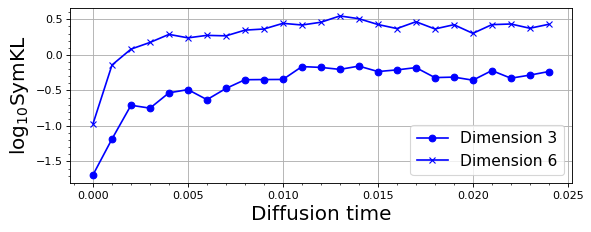

In [4]:
time_array = np.arange(25)*5e-4*2
fig, ax = plt.subplots(figsize=(7.5, 3), dpi=80,facecolor='w')
ax.set_xlabel('Diffusion time', fontsize=18)
ax.set_ylabel(r'$\log_{10}$SymKL', fontsize=18)
ax.plot(time_array, np.log(symkl_resl[0]), "-bo", label="Dimension 3")
ax.plot(time_array, np.log(symkl_resl[1]), "-bx", label="Dimension 6")
ax.legend(loc="lower right",prop={'size': 14})
plt.grid(which='major')
plt.minorticks_on()
plt.tight_layout()
plt.show()
fig.savefig("../paper_plots/porous_error.png", bbox_inches='tight', dpi=200)


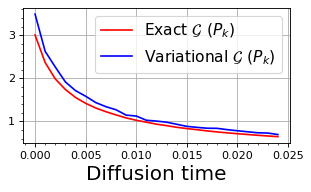

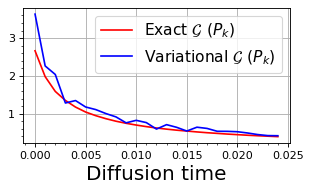

In [6]:
dims=[3,6]
for idx_dim in range(len(dims)):
    fig, ax = plt.subplots(figsize=(4, 2.5), dpi=80)
    ax.set_xlabel('Diffusion time', fontsize=18)
    ax.plot(time_array, entropy_targ[idx_dim], color="red",label=r"Exact $\mathcal{G} ~ (P_k)$")
    ax.plot(time_array,  entropy_ours[idx_dim], color="blue",label= r'Variational $\mathcal{G}~(P_k)$')
    ax.legend(loc="upper right",prop={'size':14})
    plt.grid(which='major')
    plt.minorticks_on()
    plt.tight_layout()
    # plt.show()  
    fig.savefig(f"../paper_plots/porous_var_{dims[idx_dim]}.png", bbox_inches='tight', dpi=200) 


#### Error curve tools

In [7]:
def make_conv_comp_EFM(dim, method,logdet="full"):
    config_path = f'../../PytorchSource/configs/convergence_comparison_dim_{dim}.yml'
    data_path = f'../../PytorchSource/results/gmm_logdet_{logdet}/conv_comp_dim_{dim}'
    return ConvergenceComparison_EFM.fromconfigpath(config_path, method, data_path)


def get_mean_med_int(arr, transform=np.log10, alpha=0.95):
    if transform is not None:
        arr = transform(arr)
    arr = arr[~np.isnan(arr)]
    _mean = np.mean(arr)
    _med = np.median(arr)
    S = np.sqrt(np.mean(arr**2) - _mean**2)
    z = sps.norm.ppf((1. + alpha) / 2.)
    _int = z * S / np.sqrt(len(arr))
    return _mean, _med, _int


def get_kl_sym_stats_conv_comp(dim_range, method, logdet="full", transform=np.log10):
    conv_stats = {
        'means': defaultdict(list),
        'meds': defaultdict(list),
        'ints': defaultdict(list)
    }
    for dim in dim_range:
        efm = make_conv_comp_EFM(dim, method,logdet)
        kl_sym = efm.loc('kl_sym')
        _mean, _med, _int = get_mean_med_int(kl_sym, transform=transform)
        conv_stats['means']['kl_sym'].append(_mean)
        conv_stats['meds']['kl_sym'].append(_med)
        conv_stats['ints']['kl_sym'].append(_int)
    return conv_stats


def draw_stats(dims, stats, ax, color, label, measure, legend_position='best'):
    ax.plot(dims, stats['means'][measure], color=color, label=label)
    _means = np.asarray(stats['means'][measure])
    _ints = np.asarray(stats['ints'][measure])
    ax.fill_between(
        dims,
        (_means - _ints),
        (_means + _ints), color=color, alpha=.1)


#### OU process

##### OU SymKL

In [10]:
dim_ou = [2, 6, 12, 16, 32, 64]
trials_ou = list(range(1, 16))

for num_k in [18]:
    data_path=f'../paper_plots/ou_sym_kl_0_{int(num_k/2)}.pth'
    if os.path.exists(data_path):
        conv_stats=io.load(data_path)
    else:
        conv_stats = {'means': [],'meds': [],'ints': []}
        for idx_dim in range(len(dim_ou)):
            log10symkl_array = []        
            for idx_trial in range(len(trials_ou)):
                logsymkl_value=io.load(f"../logs/papers/gauss_nonlinear/multirun/{dim_ou[idx_dim]}/{idx_trial}/log10symkl_{num_k}.pth")
                if logsymkl_value > -8.:
                    log10symkl_array.append(logsymkl_value.item())      
            _mean, _med, _int = get_mean_med_int(np.array(log10symkl_array),transform=None)
            conv_stats['means'].append(_mean)
            conv_stats['meds'].append(_med)
            conv_stats['ints'].append(_int)
        io.dump(data_path, conv_stats)

    print(conv_stats)

{'means': [-3.3439705542155673, -2.992587617465428, -2.5369048595428465, -2.361378518740336, -2.0584694226582845, -1.36652729511261], 'meds': [-3.3320322036743164, -2.979405164718628, -2.5240161418914795, -2.472763776779175, -2.0537545680999756, -1.390233039855957], 'ints': [0.16806863037783634, 0.10445202133914852, 0.059309041874014784, 0.14153369039633706, 0.07230966548233692, 0.12883803315265444]}


##### OU entropy

In [11]:
ou_entropy_results_path='../paper_plots/ou_entropy_results.pth'
num_records=20
num_exp=15
dim_entropy=64
if os.path.exists(ou_entropy_results_path):
    ou_resl=io.load(ou_entropy_results_path)
    entropy_mean_ours=ou_resl["entropy_mean_ours"]
    entropy_std_ours=ou_resl["entropy_std_ours"]
    entropy_mean_exact=ou_resl["entropy_mean_exact"]
    entropy_std_exact=ou_resl["entropy_std_exact"]
else:
    entropy_ours=np.zeros([num_records,num_exp])
    entropy_exact=np.zeros([num_records,num_exp])

    for idx_k in range(num_records):
        for idx_exp in range(num_exp):
            entropy_ours[idx_k,idx_exp]=io.load(f"../logs/papers/gauss_nonlinear/multirun/{dim_entropy}/{idx_exp}/vari_targ_{idx_k+1}.pth").item()
            entropy_exact[idx_k,idx_exp]=io.load(f"../logs/papers/gauss_nonlinear/multirun/{dim_entropy}/{idx_exp}/exact_targ_{idx_k+1}.pth").item()          

    entropy_mean_ours=entropy_ours.mean(axis=-1)
    entropy_std_ours=entropy_ours.std(axis=-1)
    entropy_mean_exact=entropy_exact.mean(axis=-1)
    entropy_std_exact=entropy_exact.std(axis=-1)    
    io.dump(ou_entropy_results_path, {
        "entropy_mean_ours":entropy_mean_ours,
        "entropy_std_ours":entropy_std_ours,
        "entropy_mean_exact": entropy_mean_exact,
        "entropy_std_exact": entropy_std_exact})

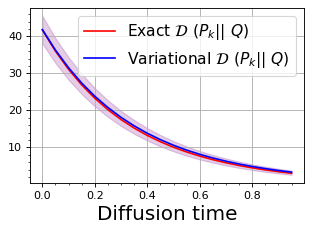

In [12]:
fig, ax = plt.subplots(figsize=(4,3), dpi=80)
ax.set_xlabel('Diffusion time', fontsize=18)

time_array=np.arange(num_records)*0.05
ax.plot(time_array, entropy_mean_exact, color="red",label=r"Exact $\mathcal{D}~(P_k || ~Q)$")
ax.fill_between(
        time_array,
        (entropy_mean_exact - entropy_std_ours),
        (entropy_mean_ours + entropy_std_ours), color="red", alpha=.1)
ax.plot(time_array,  entropy_mean_ours, color="blue",label= r'Variational $\mathcal{D}~(P_k || ~Q)$')
ax.fill_between(
        time_array,
        (entropy_mean_exact - entropy_std_ours),
        (entropy_mean_ours + entropy_std_ours), color="blue", alpha=.1)

ax.legend(loc="upper right",prop={'size':14})
plt.grid(which='major')
plt.xticks()
plt.minorticks_on()
plt.tight_layout()
# plt.show()  
fig.savefig(f"../paper_plots/ou_var_d64.png", bbox_inches='tight', dpi=200) 


#### GMM

##### GMM quality results

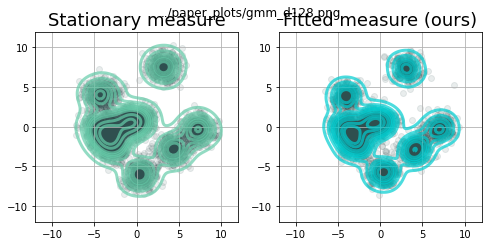

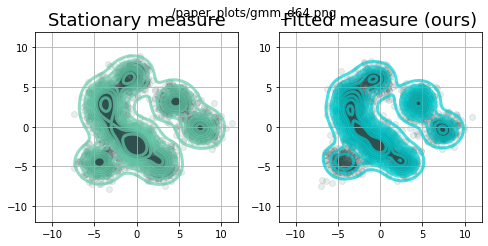

In [13]:
from src.viz.points import compare_highd_kde_scatter
gmm_data=io.load(f"../paper_plots/ours_gmm_data.pth")
target_dist=gmm_data["target_dist"][128][2]
particles=gmm_data["pk_data"][128][2]
compare_highd_kde_scatter(particles,target_dist.sample_n,"../paper_plots/gmm_d128.png",figsize=(8,3.5))
target_dist=gmm_data["target_dist"][64][2]
particles=gmm_data["pk_data"][64][2]
compare_highd_kde_scatter(particles,target_dist.sample_n,"../paper_plots/gmm_d64.png",figsize=(8,3.5))

##### GMM kde

In [41]:
num15_kde_results = io.load("../paper_plots/gmm_gm_kde_num15.csv")
num15_kde_results.sort_values(["input_dim"],axis=0,ascending=[False],inplace=True)
gmm_kde_results = (np.array(num15_kde_results["error_gmm/log10symkl"]).reshape(6, -1))
gmm_kde_results = np.flip(gmm_kde_results)

In [43]:
dims = [2, 4,8, 17, 24, 32]
trial_list = list(range(1, 6))
conv_stats = {
    'means': {'kl_sym': []},
    'ints': {'kl_sym': []}
}
for idx_dim in range(len(dims)):
    _mean, _, _int = get_mean_med_int(gmm_kde_results[idx_dim], transform=None)
    conv_stats['means']['kl_sym'].append(_mean)
    conv_stats['ints']['kl_sym'].append(_int)
io.dump(f'../paper_plots/ours_num15_kde_gmm.pth', conv_stats)


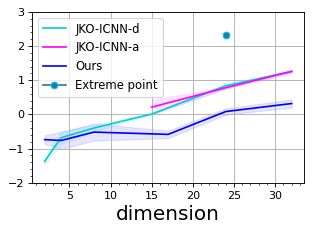

In [53]:
methods = ['ICNN_jko', 'ICNN_jko', 'ours']
names = ['JKO-ICNN-d','JKO-ICNN-a', "Ours"]
colors = ['darkturquoise', 'magenta', 'blue']
logdet = ['full', 'appro',None]
dims_icnn = [[2, 4, 8, 15, 24, 32],[15, 24,32],None]
# dims_icnn = [15, 24,32]

fig, ax = plt.subplots(figsize=(4, 3), dpi=80)
ax.set_xlabel('dimension', fontsize=18)
# ax.set_ylabel(r'$\log_{10}$SymKL', fontsize=18)
est_stat = 'kl_sym'
for method, name, color,logdet,dims_icnn in zip(methods, names, colors,logdet,dims_icnn):
    if method == 'ICNN_jko':
        fp_jko_stat = get_kl_sym_stats_conv_comp(dims_icnn, method,logdet)
        draw_stats(dims_icnn, fp_jko_stat, ax, color, name,
                   est_stat, legend_position='lower right')
    else:
        draw_stats(dims, conv_stats, ax, color, name, est_stat, legend_position='lower right')
bad_point_file=io.load("../../PytorchSource/results/gmm_15to32_full_20_steps/bad_point_dim24_recap/conv_comp_dim_24-ICNN_jko-dim=24-n_exp=2.json")
bad_point=np.log10(bad_point_file["kl_train"]+bad_point_file["kl_target"])
plt.plot(24,bad_point,'-o',markeredgecolor="darkturquoise",label="Extreme point")
ax.legend(loc="upper left",prop={'size':10.5})
ax.set_ylim((-2,3))
plt.grid(which='major')
plt.minorticks_on()
plt.tight_layout()
plt.show()
fig.savefig("../paper_plots/gmm_num15_kde.png", bbox_inches='tight', dpi=200)

##### GMM KSD

In [14]:
beta_values={}
dims=[2, 4,8,17, 24, 32,64,128]
for idx in range(8):
    beta_values[dims[idx]]=io.load(f"../paper_plots/beta_values/beta_{dims[idx]}.pth")
beta_values[8]=0.006
print(beta_values)


{2: 0.013918349462575561, 4: 0.006735497237544903, 8: 0.006, 17: 0.004090072050635304, 24: 0.002670399999891562, 32: 0.0021335196562106674, 64: 0.0017704295935291748, 128: 0.0011359962611944407}


In [25]:
from src.callbacks.metric_zoo.ksd import KSD
NUM_PARTICLES_KSD=1000
REPEAT_KSD=10
dims_list = [[2, 4,8,17, 24, 32,64,128],[2, 4, 8, 15, 24, 32], [15, 24, 32]]
trial_list = list(range(1, 6))
methods=["ours","jko_icnn_full","jko_icnn_appro"]

ksd_method="fix"
for method,dims in zip(methods,dims_list):
    data_path=f'../paper_plots/{method}_ksd_{ksd_method}_gmm.pth'
    if os.path.exists(data_path):
        results=io.load(data_path)
        gmm_ksd_mean,gmm_ksd_std = results["ksd_mean"],results["ksd_std"]
    else:
        gmm_data=io.load(f"../paper_plots/{method}_gmm_data.pth")
        gmm_ksd_results=np.zeros([len(dims),5])
        for idx_dim in range(len(dims)):
            dim_beta = dims[idx_dim] if dims[idx_dim] != 15 else 17
            default_beta_val=beta_values[dim_beta]
            for idx_repe in range(5):
                target_dist=gmm_data["target_dist"][dims[idx_dim]][idx_repe]
                
                tmp_ksd=0
                for idx_batch in range(REPEAT_KSD):
                    particles=gmm_data["pk_data"][dims[idx_dim]][idx_repe][NUM_PARTICLES_KSD*idx_batch:NUM_PARTICLES_KSD*(idx_batch+1)].to(target_dist.sample_n(1).device) 

                    if ksd_method == "fix":
                        ksd = KSD(target_dist.log_prob,beta=default_beta_val)            
                        tmp_ksd += ksd(particles).item()
                    elif ksd_method == "tune":
                        tmp_ksd += ksd(particles,adjust_beta=True).item()
                    elif ksd_method == "worse":
                        pass
                        
                gmm_ksd_results[idx_dim,idx_repe] = np.log10(tmp_ksd/REPEAT_KSD)

        gmm_ksd_mean=gmm_ksd_results.mean(axis=-1)
        gmm_ksd_std=gmm_ksd_results.std(axis=-1)
        io.dump(data_path, {"ksd_mean":gmm_ksd_mean,"ksd_std": gmm_ksd_std})

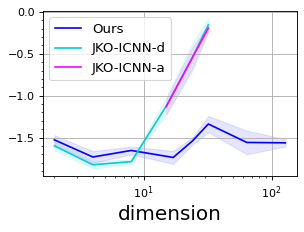

In [26]:
names = ['Ours','JKO-ICNN-d','JKO-ICNN-a']
colors = ['blue','darkturquoise', 'magenta']
for ksd_method in ["fix"]:
# for ksd_method in ["fix","tune","worse"]:
    fig, ax = plt.subplots(figsize=(4, 3), dpi=80,facecolor='w')
    ax.set_xlabel("dimension", fontsize=18)
    for dims,method,name,color in zip(dims_list,methods,names,colors):
        stats=io.load(f'../paper_plots/{method}_ksd_{ksd_method}_gmm.pth')
        mean=stats["ksd_mean"]
        std=stats["ksd_std"]
        ax.plot(dims, mean, color=color,label= name)
        ax.fill_between(
            dims,
            (mean - std),
            (mean + std), color=color, alpha=.1)
    ax.set_xscale('log')
    ax.legend(loc="best",prop={'size':12})
    plt.grid(which='major')
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()  
    fig.savefig(f"../paper_plots/gmm_ksd_{ksd_method}_beta.png", bbox_inches='tight', dpi=200) 

##### GMM run time

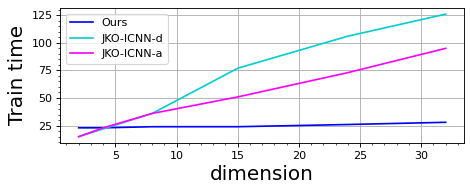

In [20]:
dims_for_time = np.array([2, 4,8, 15, 24, 32])
names = ["Ours", 'JKO-ICNN-d','JKO-ICNN-a']
colors = ['blue','darkturquoise', 'magenta']
times=[np.array([23 , 23 , 24 , 24 , 26  , 28 ]),
np.array([15 , 22 , 36 , 77 , 106 , 126]),
np.array([15 , 23 , 36 , 51 , 73  , 95]),
]
fig, ax = plt.subplots(figsize=(6, 2.5), dpi=80)
ax.set_xlabel('dimension', fontsize=18)
ax.set_ylabel("Train time", fontsize=18)
for time, name, color in zip(times, names, colors):
    plt.plot(dims_for_time, time, color=color,label=name)
ax.legend(loc="upper left")
plt.grid(which='major')
plt.minorticks_on()
plt.tight_layout()
plt.show()  
fig.savefig("../paper_plots/gmm_time.png", bbox_inches='tight', dpi=200)  

##### GMM entropy convergence

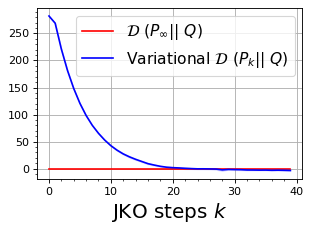

In [24]:
time_array = np.arange(40)
target_values=np.zeros([40,5])
zero_values=np.zeros(40)
dims=64
data_path=f'../paper_plots/gmm_d64_var_target.pth'
if os.path.exists(data_path):
    results=io.load(data_path)
    targ_mean,targ_std = results["targ_mean"],results["targ_std"]
else:
    for idx_repe in range(5):
        for idx_k in range(40):
            target_values[idx_k,idx_repe]=io.load(f"../logs/papers/gmm/multirun/{dims}/{idx_repe+1}/vari_targ_{idx_k+1}.pth")
    targ_mean=target_values.mean(axis=-1)
    targ_std=target_values.std(axis=-1)
    io.dump(data_path, {"targ_mean":targ_mean,"targ_std": targ_std})

fig, ax = plt.subplots(figsize=(4, 3), dpi=80)
ax.set_xlabel(r'JKO steps $k$', fontsize=18)
# ax.set_ylabel(r'Variational $\mathcal{F}(P)$', fontsize=18)
ax.plot(time_array, zero_values, color="red",label=r"$\mathcal{D}~(P_\infty || ~Q )$")
ax.plot(time_array, targ_mean, color="blue",label= r'Variational $\mathcal{D}~(P_k || ~Q)$')
ax.fill_between(
    time_array,
    (targ_mean - targ_std),
    (targ_mean + targ_std), color="blue", alpha=.1)
ax.legend(loc="upper right",prop={'size':14})
plt.grid(which='major')
plt.minorticks_on()
plt.tight_layout()
plt.show()  
fig.savefig("../paper_plots/gmm_var_target.png", bbox_inches='tight', dpi=200) 